* This file takes a raw file and splits into per day files ( manually )
* The luigi task then processes each per day file, cleans, adds extra fields
* It also calcuates the runs and writes the output files

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import pandas as pd
import numpy as np
from datetime import datetime
import luigi
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set()

In [4]:
%matplotlib inline

In [5]:
from skitracker_utils import ProcessDirectory, ProcessTask, InFile


In [62]:
project_root = '/home/jjc/Projects/SkiTracker/'

In [40]:
input_file = 'raw_data_collected/sam_chamonix_messy.csv'

In [41]:
raw  =pd.read_csv(input_file, header=None, names=['Date','Time','Lat','Lon','GPS_Alt','Pressure','Pres_Alt','Temp','Batt'])

In [42]:
#remove the first line if its text
raw=raw[1:]
raw.shape

(99209, 9)

In [43]:
raw.head()

,Date,Time,Lat,Lon,GPS_Alt,Pressure,Pres_Alt,Temp,Batt
1,03/22/2019,09:57:57,45.099696,6.059256,2115.8,79813.875,1968.105,28.91,4.325
2,03/22/2019,09:57:59,45.099696,6.059264,2115.3,79805.703,1968.931,28.91,4.331
3,03/22/2019,09:58:00,45.099698,6.059271,2115.7,79805.812,1968.920,28.92,4.325
4,03/22/2019,09:58:01,45.099696,6.059280,2115.9,79812.703,1968.224,28.93,4.325
5,03/22/2019,09:58:02,45.099694,6.059289,2117.1,79815.219,1967.969,28.94,4.325


In [44]:
raw.Date.unique()

array(['03/22/2019 ', '04/08/2019 ', '******12:11:58 ', '04/09/2019 ',
       '******12:04:16 ', '******12:20:27 ', '******13:42:07 ',
       '04/10/2019 ', '******13:46:01 '], dtype=object)

In [55]:
raw_filter = raw[raw.Date=='04/10/2019 ']

In [56]:
raw_filter.shape

(4368, 9)

In [57]:
name = 'sam'
location = 'FR'
date = datetime(2020,4,10)
output_file = '{}_{}_{}.pkl'.format(name,location,date.strftime('%d%b%y'))
output_file

'sam_FR_10Apr20.pkl'

In [58]:
raw_filter.to_pickle('raw_split_files/'+output_file)

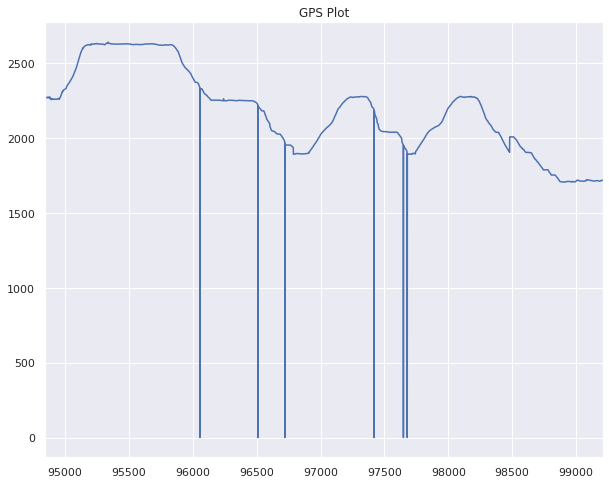

In [59]:
fig, ax = plt.subplots(figsize=(10,8))
raw_filter['GPS_Alt'].plot(ax=ax, title='GPS Plot')
plt.show()
#raw_filter['GPS_Alt'].plot()

### Luigi Process

In [63]:
process_all  = ProcessDirectory(inputDir=project_root+'raw_split_files/',outputDir=project_root+'processed_data/')

In [68]:
luigi.build([process_all],local_scheduler=True)

DEBUG: Checking if ProcessDirectory(inputDir=/home/jjc/Projects/SkiTracker/raw_split_files/, outputDir=/home/jjc/Projects/SkiTracker/processed_data/) is complete
DEBUG: Checking if ProcessTask(file_name=sam_FR_10Apr20.pkl, inputDir=/home/jjc/Projects/SkiTracker/raw_split_files/, outputDir=/home/jjc/Projects/SkiTracker/processed_data/) is complete
DEBUG: Checking if ProcessTask(file_name=sam_FR_08Apr20.pkl, inputDir=/home/jjc/Projects/SkiTracker/raw_split_files/, outputDir=/home/jjc/Projects/SkiTracker/processed_data/) is complete
DEBUG: Checking if ProcessTask(file_name=jon_BG_18Jan20.pkl, inputDir=/home/jjc/Projects/SkiTracker/raw_split_files/, outputDir=/home/jjc/Projects/SkiTracker/processed_data/) is complete
DEBUG: Checking if ProcessTask(file_name=sam_FR_09Apr20.pkl, inputDir=/home/jjc/Projects/SkiTracker/raw_split_files/, outputDir=/home/jjc/Projects/SkiTracker/processed_data/) is complete
DEBUG: Checking if ProcessTask(file_name=josh_BG_17Jan20.pkl, inputDir=/home/jjc/Projects/

True

In [ ]:
# debug

In [19]:
df = pd.read_pickle('raw_split_files/josh_17Mar19.pkl')

In [20]:
df.head()

,Date,Time,Lat,Lon,GPS_Alt,Pressure,Pres_Alt,Temp,Batt
26034,03/17/2019,08:44:03,45.097191,6.069313,0.0,1.100222e+10,1859.802,23.4,4.022
26035,03/17/2019,08:44:04,45.097191,6.069315,1867.0,1.100222e+10,1860.903,23.4,3.945
26036,03/17/2019,08:44:05,45.097191,6.069309,1867.1,1.100222e+10,1860.602,23.4,3.925
26037,03/17/2019,08:44:06,45.097195,6.069302,1867.2,1.100222e+10,1859.802,23.5,3.938
26038,03/17/2019,08:44:07,45.097195,6.069293,1867.0,1.100222e+10,1860.703,23.5,3.938


In [21]:
from skitracker_utils import find_routes, prepare_data

In [22]:
df = prepare_data(df)

In [23]:
runs = find_routes(df)

In [24]:
for i, run in enumerate(runs):
    print(i, run['scale'])

0 5.814194836983694
1 5.944191166440021
2 6.355485670423555
3 8.529248018342143
4 8.976568430178716
5 5.583955214190283
6 6.4812934693615105
7 4.6784004290629255
8 5.334170275938502
9 6.820314180491962
10 6.891502908832487
11 1.2122750699281015
